In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START , END
from typing import TypedDict, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [4]:
load_dotenv()
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [5]:
class EvaluationSchema(BaseModel):
    
    feedback : str = Field(description = 'Detailed feedback for the essay')
    score : int = Field(description='Score out of 10', ge=0, le=10)

In [6]:
structured_model = model.with_structured_output(EvaluationSchema)

In [7]:
essay =  """
Generative AI (GenAI) is designed to produce content such as text, images, code, or music based on specific user prompts or instructions.

Agentic AI is built to autonomously perform multi-step, goal-oriented tasks with minimal human intervention, making decisions and taking actions proactively.

GenAI is reactive; it responds to user input by generating outputs, while Agentic AI is proactive, initiating actions and solving problems without waiting for direct instructions.

GenAI excels in creative automation, content drafting, summarization, and transforming technical information into plain language.

Agentic AI specializes in workflow automation, decision-making, coordinating across tools and platforms, and adjusting tasks dynamically if circumstances change.

GenAI’s underlying technologies include generative adversarial networks (GANs) and transformer models (e.g., GPT, BERT).

Agentic AI relies on reinforcement learning, multi-agent systems, decision trees, robotics frameworks, and sensor fusion for environmental interaction.

GenAI requires step-by-step user direction for each output; Agentic AI operates independently once given a goal, adapting as needed to reach the objective.

GenAI’s output is typically creative and informational, meant to assist, inspire, or communicate, but generally non-functional.

Agentic AI’s output is functional, involving navigation, execution of business processes, problem-solving, or coordination tasks.

GenAI’s strengths include speed, enhancement of human innovation, and scalability in content creation.

Agentic AI’s strengths are autonomy, efficiency, adaptability, and scalability for handling complex, dynamic environments.

GenAI can be limited by its training data, leading to biased or nonsensical outputs; careful prompting and fact-checking are essential.

Agentic AI introduces complexity in orchestration, security, and ethical oversight due to its independent decision-making ability.

"""

In [9]:
prompt = f'Evalute the language qulaity of the folloiwng essay and provide a feedback and assign a score out of 10 \n {essay}'

structured_model.invoke(prompt)

EvaluationSchema(feedback='The essay provides a clear and concise comparison of Generative AI and Agentic AI, highlighting their key differences in functionality, underlying technologies, strengths, and limitations.  The language used is precise and accessible, making the information easy to understand.  A minor improvement could be to add a concluding sentence summarizing the overall distinctions between the two types of AI. ', score=9)

In [21]:
import operator 

class UPSCSState(TypedDict):

    essay : str
    language_feedback : str
    analysis_feedback : str
    clarity_feedback : str

    overall_feedback : str
    individual_scores : Annotated[list[int], operator.add]  # Reducer func to add list[] + [] + []

    avg_score : float

In [22]:
def evalute_language(state: UPSCSState):
    prompt = f'Evalute the language qulaity of the folloiwng essay and provide a feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)
    return { 'language_feedback': output.feedback, 'individual_scores':[output.score]}

In [23]:
def evalute_analysis(state: UPSCSState):
    prompt = f'Evalute the depth of analysis of the folloiwng essay and provide a feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)
    return { 'analysis_feedback': output.feedback, 'individual_scores':[output.score]}

In [24]:
def evalute_thought(state: UPSCSState):
    prompt = f'Evalute the clarity of thought of the folloiwng essay and provide a feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)
    return { 'clarity_feedback': output.feedback, 'individual_scores':[output.score]}

In [25]:
def final_evalaution(state: UPSCSState):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n Language feedback - {state['language_feedback']} \n Depth of analysis feedback - {state['analysis_feedback']} \n Clarity of thought - {state['clarity_feedback']}'

    overall_feedback = model.invoke(prompt).content
    

    #  avg claculate 
    avg_score = sum(state['individual_scores'])/len((state['individual_scores']))

    return {'overall_feedback' : overall_feedback, 'avg_score':avg_score }

In [37]:
graph = StateGraph(UPSCSState)

graph.add_node('evalute_language',evalute_language)
graph.add_node('evalute_analysis',evalute_analysis)
graph.add_node('evalute_thought',evalute_thought)
graph.add_node('final_evalaution',final_evalaution)

# ----------- Edges -----------

graph.add_edge(START, 'evalute_language')
graph.add_edge(START, 'evalute_analysis')
graph.add_edge(START, 'evalute_thought')

graph.add_edge('evalute_language', 'final_evalaution')
graph.add_edge('evalute_analysis', 'final_evalaution')
graph.add_edge('evalute_thought', 'final_evalaution')

graph.add_edge('final_evalaution', END)

workflow = graph.compile()


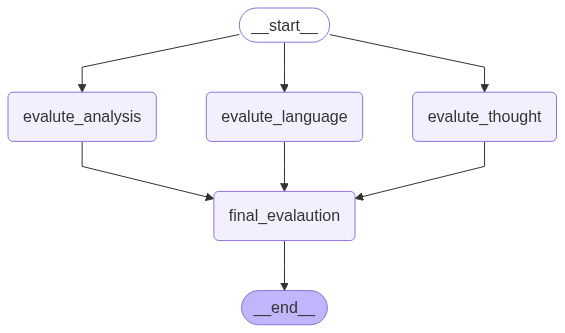

In [41]:
workflow

In [52]:
initial_state = {
    'essay':essay2
}

final_output = workflow.invoke(initial_state)

In [53]:
final_output

{'essay': '\n\nGenAI use thingz like GANS, transformatrs like GPT or BERT n other AI stuff.\n\nAgentik AI use learnin stuff, multy-agent thingys, decision trez, robott stuff n sensors 2 kno wat around.\n\nGenAI need u 2 tell step by step wat 2 do, Agentik AI just do goal stuff by itself.\n\nGenAI make creative or info stuff 2 help ppl, Agentik AI make useful stuff like solv probz or do taskz.\n\nGenAI fast, helps ppl make lots of stuff, can make many thingz.\n\nAgentik AI do stuff by itself, efficent, adapt if needd, can handle complx stuffz.\n\nGenAI somtime give bad or bias stuff, u need check it.\n\nAgentik AI more complicatd, can hav securty or ethic probz becuz it do stuff it self.\n',
 'language_feedback': 'The essay provides a clear and concise comparison of Generative AI and Agentic AI, highlighting their key differences in functionality, underlying technologies, strengths, and limitations.  The language used is precise and accessible, effectively conveying complex concepts.  T

In [51]:
essay2 = '''

GenAI use thingz like GANS, transformatrs like GPT or BERT n other AI stuff.

Agentik AI use learnin stuff, multy-agent thingys, decision trez, robott stuff n sensors 2 kno wat around.

GenAI need u 2 tell step by step wat 2 do, Agentik AI just do goal stuff by itself.

GenAI make creative or info stuff 2 help ppl, Agentik AI make useful stuff like solv probz or do taskz.

GenAI fast, helps ppl make lots of stuff, can make many thingz.

Agentik AI do stuff by itself, efficent, adapt if needd, can handle complx stuffz.

GenAI somtime give bad or bias stuff, u need check it.

Agentik AI more complicatd, can hav securty or ethic probz becuz it do stuff it self.
'''